In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
import random

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind

In [4]:
%matplotlib widget

#### Load EEGexp object

In [5]:
rec_folder = r'R:\mouse771426\THstim_d1_2024-12-19_12-19-39\experiment1\recording1' # points to folder containing stim_table.csv
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [24]:
mask_probe = 'probeD'

In [25]:
# make paths
stim_log_path = exp.stimulus_log_file
probe_info = exp.ephys_params[mask_probe]['probe_info']
ap_raw = exp.ephys_params[mask_probe]['ap_continuous']
ap_time_path = exp.ephys_params[mask_probe]['ap_timestamps']

# paths for artifact (this code creates these files at the end, not necessary to have them, but should specify where you want them saved)
artinds_path = os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'artifact_onset_inds.npy')
arttimes_path = os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'artifact_onset_master_clock.npy')
maskdur_path = os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'mask_sampleduration.npy')

#### Set number of samples to mask

In [26]:
# stim_ind_break = np.array([0, 1200, 1400]) # choose ends of stim
masks = np.array([60]) # samples to obscure, basically length of artifact you want to remove (60 = 2 ms)

#### Load raw data

In [27]:
numCh = exp.ephys_params[mask_probe]['num_chs']
# AP band raw
rawDatamm = np.memmap(ap_raw, dtype='int16', mode='r') # r+ will allow the file to be changed
datamm = np.reshape(rawDatamm, (int(rawDatamm.size/numCh), numCh))
samp_rate = exp.ephys_params[mask_probe]['ap_sample_rate']
timestamps = np.load(ap_time_path)

#### If there is a "permission denied" error here, try running mode='r' and then retry mode='r+'.

In [28]:
print(datamm.shape)
print(timestamps.shape)

(198019788, 384)
(198019788,)


In [29]:
print(timestamps[0:5])

[34.70750233 34.70753566 34.70756899 34.70760233 34.70763566]


#### Load estim times. Should use stimulus times that would be associated with an artifact.

In [30]:
stim_table = pd.read_csv(stim_log_path)
# get only e-stim times
estim_times = stim_table[stim_table['stim_type'] == 'biphasic'].onset.values

stim_inds = np.array([find_nearest_ind(timestamps, x) for x in estim_times])
len(stim_inds)

46000

In [31]:
print(stim_inds[0:9])
print(np.sum(np.isnan(stim_inds)))

[41016182 41016782 41017382 41017982 41018582 41019182 41019782 41020382
 41020982]
0


In [32]:
mask_inds = stim_inds - 2 # this corrects for minimal sample offset between estim_times and actual beginning of artifact

#### Finds 'inds': times in recording where you may find artifacts, mainly this allows you to not load raw data that does not have artifacts. I.e. beginning of recording that has only visual stimuli.

In [33]:
inds = np.arange(stim_inds[0]-samp_rate, stim_inds[-1]+samp_rate)
stim_inds_short = stim_inds - inds[0]

In [34]:
print(len(inds))

129851307


In [35]:
estim_onset = stim_inds_short - 2 # this corrects for minimal sample offset between estim_times and actual beginning of artifact
print(estim_onset[0:3])

[29998 30598 31198]


In [36]:
# This is supposed to be a sanity check to make sure the code is masking only artifacts associated with chosen stimuli
if len(estim_onset) >= len(stim_inds):
    print('Good to go')
    print('artifacts found: %d' % len(estim_onset))
else:
    print('Umm, check the peak finding step?')

Good to go
artifacts found: 46000


### Load data to plot and check masking

In [37]:
rawData = datamm[inds, 15] # choose one ch to load here

#### Copy rawData and mask the artifact

In [38]:
cleanData = np.copy(rawData) # this array is 1D

In [39]:
mask_samples = 30

In [40]:
start = time.time()
for val in estim_onset:
    if np.isnan(val):
        continue
    else:
        val = int(val)
        cleanData[val:val+mask_samples] = cleanData[val:val-mask_samples:-1] # this array is 1D
end = time.time()
print(end-start)

0.13703513145446777


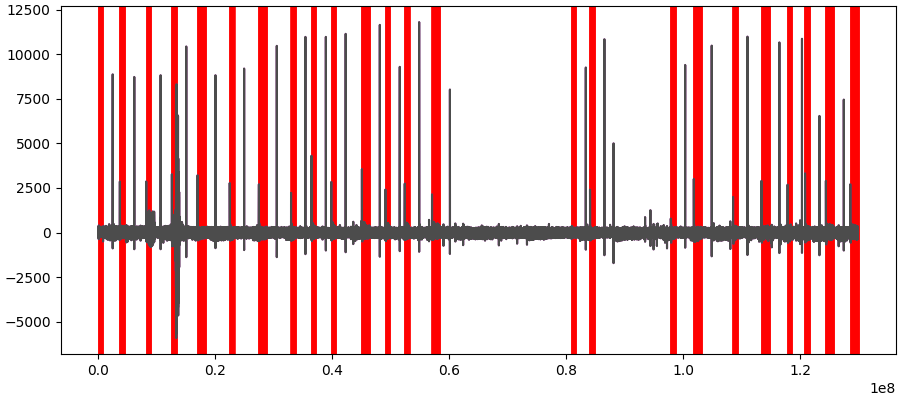

In [41]:
# This plot takes a lot of memory when loading one ch for the whole recording
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)
ax.plot(rawData, 'm')
ax.plot(cleanData, 'g', alpha=0.6)
for val in estim_onset:
    if np.isnan(val):
        continue
    else:
        val = int(val)
        art_beg = val
        art_end = art_beg + mask_samples
        ax.axvspan(art_beg, art_end, alpha=0.3, color='red')

#### End of plotting

### Loop through mask_inds, load small chunks of data, and mask artifact

#### This actually alters the continuous.dat file. If you flush the changes to disk, you cannot recover the original data unless you re-extract or have a copy lying around somewhere.

In [29]:
## Just one mask length for all stims
start = time.time()
maskj = masks[0]
for val in mask_inds:
    if np.isnan(val):
        continue
    else:
        val = int(val)
        datamm[val:val+maskj,:] = datamm[val:val-maskj:-1,:] # now this is 2D
#         datamm[val:val+(mask_samples+30),:] = datamm[val:val-(mask_samples+30):-1,:]
end = time.time()
print(end-start)

0.04803156852722168


### Flush resulting masked raw data to memory/disk/whatever

In [30]:
del(datamm)
del(rawDatamm)

### Save mask_inds, so I will know exactly what sections of data have been masked. Maybe save duration also.

#### Save artifact_onset and mask_duration as .npy inside probe folder...could be incorporated into probe_info.json in future

In [31]:
print(len(mask_inds))

900


In [32]:
mask_samples = masks[0]

In [33]:
maskon_in_seconds = np.zeros_like(mask_inds, dtype='float64')
for ind, val in enumerate(mask_inds):
    if np.isnan(val):
        maskon_in_seconds[ind] = np.nan
    else:
        val = int(val)
        maskon_in_seconds[ind] = timestamps[val]
print(maskon_in_seconds[0])
print(len(maskon_in_seconds))

130.8422174856812
900


In [34]:
artifact_file = Path(artinds_path)
if artifact_file.is_file():
    print('Artifact onset files already exist')
else:
    np.save(os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'artifact_onset_inds.npy'), mask_inds)
    np.save(os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'artifact_onset_master_clock.npy'), maskon_in_seconds)
    np.save(os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'mask_sampleduration.npy'), mask_samples)
    print('Artifact files saved to probe folder')

Artifact files saved to probe folder
